In [61]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn import Module
from tqdm import tqdm
import numpy as np

from env.env_simple_move import HumanMoveSimpleAction

from pytz import timezone
from datetime import datetime

TZ = timezone('Europe/Moscow')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
DEVICE

device(type='cuda')

In [63]:
class MoveNet(Module):
    def __init__(self, n_state, n_action, n_hidden=256, lr=0.005):
        super(MoveNet, self).__init__()
        self.criterion = torch.nn.MSELoss()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
            )
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr)

    def forward(self, state):
        return self.net(state)

    def update(self, state, action):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        action = torch.tensor(action, dtype=torch.float32, device=DEVICE)
        action_by_net = self.net(state)
        loss = self.criterion(action_by_net, action)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        action = self.forward(state)
        action = action.detach().cpu().numpy()[0]
        action = np.clip(action, -1.0, 1.0)
        return action
    
        


In [64]:
env = HumanMoveSimpleAction()
n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
n_hidden = 256
lr = 0.005
model = MoveNet(n_state, n_action, n_hidden, lr).to(DEVICE)


In [65]:
n_episode = 100
total_reward_episode = np.zeros(n_episode)

for n in tqdm(range(n_episode)):

    state, _ = env.reset(seed=42)
    
    is_done = False
    is_break = False
    sum_reward = 0

    while not is_done and not is_break:
        action = model.get_action(state)
        teach_action = env.teach_action(state)

        next_state, reward, is_done, is_break, _ = env.step(action)
        sum_reward += reward

        model.update(state, teach_action)
        state = next_state

    total_reward_episode[n] = sum_reward

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


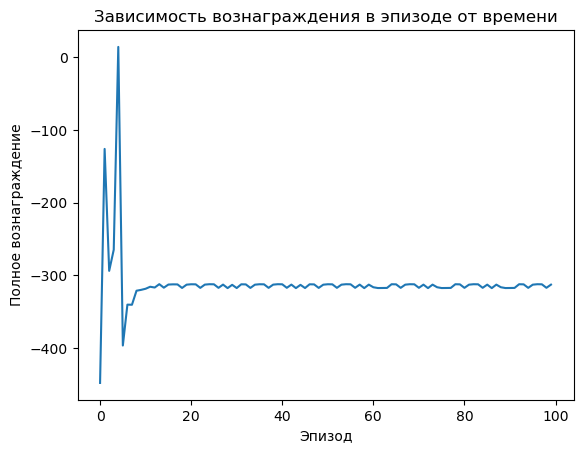

In [66]:
import matplotlib.pyplot as plt

plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [69]:
seed = 42#int( datetime.now(TZ).strftime("%H%M%S") )
env_render = HumanMoveSimpleAction(seed=seed, render_mode = 'human')
total_reward = 0.
step_reward = []
observation, _ = env_render.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    action = model.get_action(observation)

    observation, reward, terminated, truncated, _ = env_render.step(action)
    total_reward += reward
    step_reward.append(reward)

total_reward

-314.34094344923216

In [70]:
env_render.close()